In [3]:
# Library Import
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [4]:
# Data load
# Data Not Labeling(Underscore '_')
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [5]:
# data pixel check
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [6]:
# Pixel Nomalization
train_x = (train_x-127.5)/127.5 # [[YOUR CODE]]

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
train_x.shape

(50000, 32, 32, 3)

In [8]:
# Add Channel
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

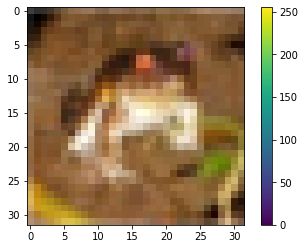

In [9]:
# Data Check[0]
plt.imshow((train_x[0] * 127.5 + 127.5).astype(np.uint8))
plt.colorbar()
plt.show()

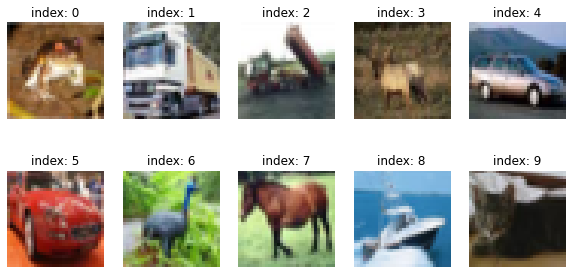

In [10]:
# Color Check
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_x[i] * 127.5 + 127.5).astype(np.uint8))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [11]:
# 25개 이미지 체크 생략
# 섞기 & 배치 (전체 데이터 섞기)
BUFFER_SIZE = 50000
BATCH_SIZE = 128

In [12]:
# 셔플 & 미니배치 데이터셋에 적용
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 생성자 구현하기

In [40]:
# DCGAN model 구현
def make_generator_model():
    model = tf.keras.Sequential()

    # 첫 번째 레이어: Dense
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU())

    # 두 번째 레이어: Reshape
    model.add(layers.Reshape((8, 8, 256)))

    # 세 번째 레이어: Conv2DTranspose
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 네 번째 레이어: Conv2DTranspose
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 다섯 번째 레이어: Conv2DTranspose
    model.add(layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
#     model.add(layers.MaxPooling2D())
    model.add(layers.LeakyReLU())
   
    # 여섯 번째 레이어: Conv2DTranspose
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    return model


In [41]:
# Model Summary
generator = make_generator_model()

generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 16, 16, 64)       

In [42]:
# 생성자 모델에서 생성되는 노이즈 확인
noise = tf.random.normal([1, 100])

In [43]:
# tensorflow 2.0 이후의 call method 활용해서 noise형태 시각화

generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

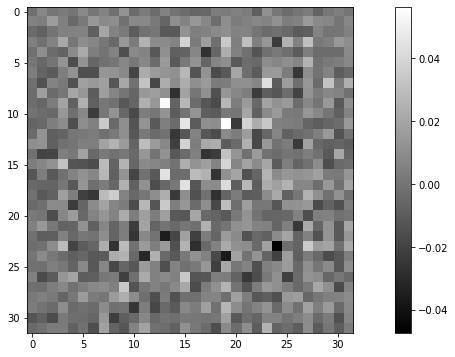

In [44]:
# 이미지 시각화
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# 판별자 구현하기

In [45]:
# 판별자 모델 구현
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 첫 번째 레이어: Conv2D
    model.add(layers.Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 두 번째 레이어: Conv2D
    model.add(layers.Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # 세 번째 레이어: Flatten
    model.add(layers.Flatten())

    # 네 번째 레이어: Dense
    model.add(layers.Dense(1))

    return model

In [46]:
# 판별자 model summary
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [47]:
# fake_img 를 판별자에 입력
# 텐서 출력인데 뭔 의미야?
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00124131]], dtype=float32)>

In [48]:
# # Lossfunction (Cross Entropy)
# # Binary cross entropy
# # from_logits를 True로 설정(keras 함수, input 0~1확률값 가정)
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [49]:
# # 생성자 Lossfunction
# def generator_loss(fake_output):
#     return cross_entropy(tf.ones_like(fake_output), fake_output)

In [50]:
# # 판별자 Lossfunction
# def discriminator_loss(real_output, fake_output):
#     real_loss = cross_entropy(tf.ones_like(real_output), real_output)
#     fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
#     total_loss = real_loss + fake_loss
#     return total_loss

In [51]:
# 노드와 다르게 Loss function 변경 (LSGAN)
# Least Squares LF
# 생성자의 Least Squares Loss Function
# def generator_loss(fake_output):
#     return tf.reduce_mean((fake_output - 1) ** 2)

def generator_loss(fake_output):
    return tf.reduce_mean(tf.square(fake_output - 1))

# 판별자의 Least Squares Loss Function
def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean((real_output - 1) ** 2)
    fake_loss = tf.reduce_mean(fake_output ** 2)
    total_loss = (real_loss + fake_loss) * 0.5  # 평균을 내서 손실을 계산합니다.
    return total_loss

In [52]:
# 판별자 & 생성자 metrics(acc)
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [53]:
# Optimizer function
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

In [54]:
# 생성자 샘플 확인
# 고정된 샘플로 해야 과정 확인 가능 (seed 설정)
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

train_step 함수를 하나하나 뜯어보면 다음과 같습니다.

(1) 입력 데이터: Real Image 역할을 할 images 한 세트를 입력으로 받음

(2) 생성자 입력 노이즈 : generator가 FAKE IMAGE를 생성하기 위한 noise를 images 한 세트와 같은 크기인 BATCH_SIZE 만큼 생성함

(3) tf.GradientTape()는 가중치 갱신을 위한 Gradient를 자동 미분으로 계산하기 위해 with 구문 열기

(4) generated_images 생성 : generator가 noise를 입력받은 후 generated_images 생성

(5) discriminator 판별 : discriminator가 Real Image인 images와 Fake Image인 generated_images를 각각 입력받은 후 real_output, fake_output 출력

(6) loss 계산 : fake_output, real_output으로 generator와 discriminator 각각의 loss 계산

(7) accuracy 계산 : fake_output, real_output으로 discriminator의 정확도 계산

(8) gradient 계산 : gen_tape와 disc_tape를 활용해 gradient를 자동으로 계산

(9) 모델 학습 : 계산된 gradient를 optimizer에 입력해 가중치 갱신

(10) 리턴값 : 이번 스텝에 계산된 loss와 accuracy를 리턴

In [55]:
# 파이썬의 Decorator 활용 (@tf.function)
# tf.graph node가 될 수 있는 타입을 변환 (데코레이터)
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [56]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :].numpy() * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [57]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [58]:
# checkpoint_model 저장
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 모델 학습

In [59]:
# 학습
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [64]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

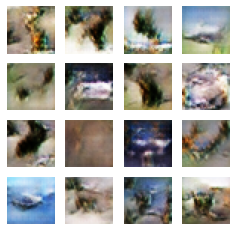

Time for training : 2053 sec


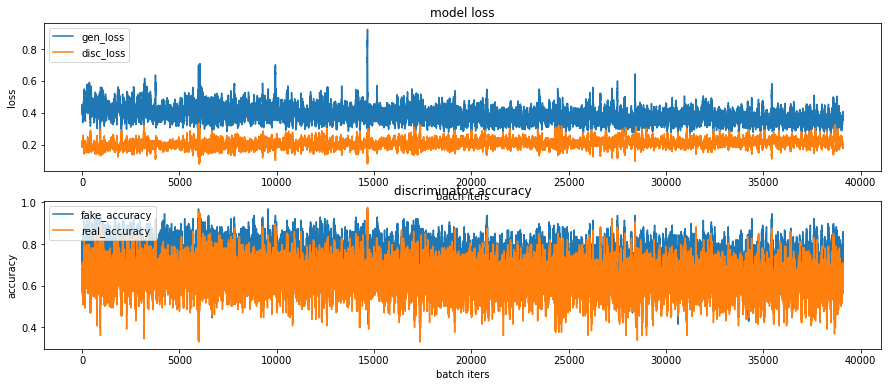

CPU times: user 21min 38s, sys: 3min 30s, total: 25min 9s
Wall time: 34min 16s


In [65]:
%%time

train(train_dataset, EPOCHS, save_every)
# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

In [35]:
# Imageio로 데이터(append) 붙여가면서 저장
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif

-rw-r--r-- 1 root root 1715059 Nov 30 08:09 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_mnist_dcgan.gif


# 회고록

* 성능 향상을 위한 테스트
1. 판별자가 판별을 너무 잘하는 경향이 있어 보임 : 판별자 고정, 생성자 모델 복잡도 상승, lr 감소

2. 1번 테스트로 Fake img만 너무 잘 맞추게 편향 됨 : Loss function 수정(찾아보니 LSGAN에서 쓰는 함수 있었음!)
(Vanishing gradient 방지를 위해 오차제곱근 도입, 구조가 0,1일때 그레디언트 소실 걱정됨)

3. 성능 향상 되어 보임(본인 판단), 마지막으로 생성자가 좀 더 완벽한 이미지 생성을 위해 모델의 복잡성 증가와 LrS 도입 예정

## 자세한 회고는 README.md에 작성했습니다!